# Recoinize

# 1. Setup

## 1.1. Pull code from GitHub

In [1]:
!git fetch --all
 
# Switch to the "live-edit" branch, ignore local changes, and pull the latest changes
!git checkout live-edit
!git reset --hard
!git pull

Fetching origin
Already on 'live-edit'
Your branch is up to date with 'origin/live-edit'.
HEAD is now at 0dc08c4 auto: update dataset.py
Already up to date.


ss


In [2]:
!nvidia-smi

Thu Jan 19 11:26:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        Off  | 00000000:00:05.0 Off |                  Off |
| 26%   22C    P8     5W / 180W |      2MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1.2. Define constants

Settings are in the top of the notebook, so you can easily change them.

## 1.3. Install dependencies

In [3]:
from helpers.install import install_requirements

# install_requirements()

## 1.4. Import dependencies

In [4]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

# Import tensorflow dependencies - Functional API
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model

2023-01-19 11:26:53.931382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 11:26:54.887457: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-19 11:26:54.887710: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/dist

## 1.5 Set GPU Growth

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# 2. Get data

This folder names are defined in our script (cf. this [repo](https://github.com/photonsquid/Recoinize-generator)) that generates the dataset.
Then it is uploaded to our [Hugging Face dataset](https://huggingface.co/datasets/photonsquid/coins-euro).

In [13]:
ROOT_PATH = "data/tests"
TRAIN_PATH = "train"
TEST_PATH = "test"

train_path = os.path.join(ROOT_PATH, TRAIN_PATH)
test_path = os.path.join(ROOT_PATH, TEST_PATH)


def load_dataset(path):
    images = []
    labels = []

    for image_name in os.listdir(path):
        image = cv2.imread(os.path.join(path, image_name))
        image = cv2.resize(image, (105, 105))
        images.append(image)

        # remove the extension from the image name
        label = image_name.split(".")[0]
        # get the country, coin_value, specificity and id
        label = label.split("_")
        country = label[0]
        coin_value = label[1]
        id = label[-1]
        # specificity is all other elements
        specificity = "_".join(label[2:-1])

        labels.append({
            "country": country,
            "coin_value": coin_value,
            "specificity": specificity,
            "id": id
        })

    return images, labels


In [15]:
# import imagrs into a tensor flow dataset
train_images, train_labels = load_dataset(train_path)
test_images, test_labels = load_dataset(test_path)

# convert the images to numpy arrays
train_images = np.array(train_images)
test_images = np.array(test_images)

# normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

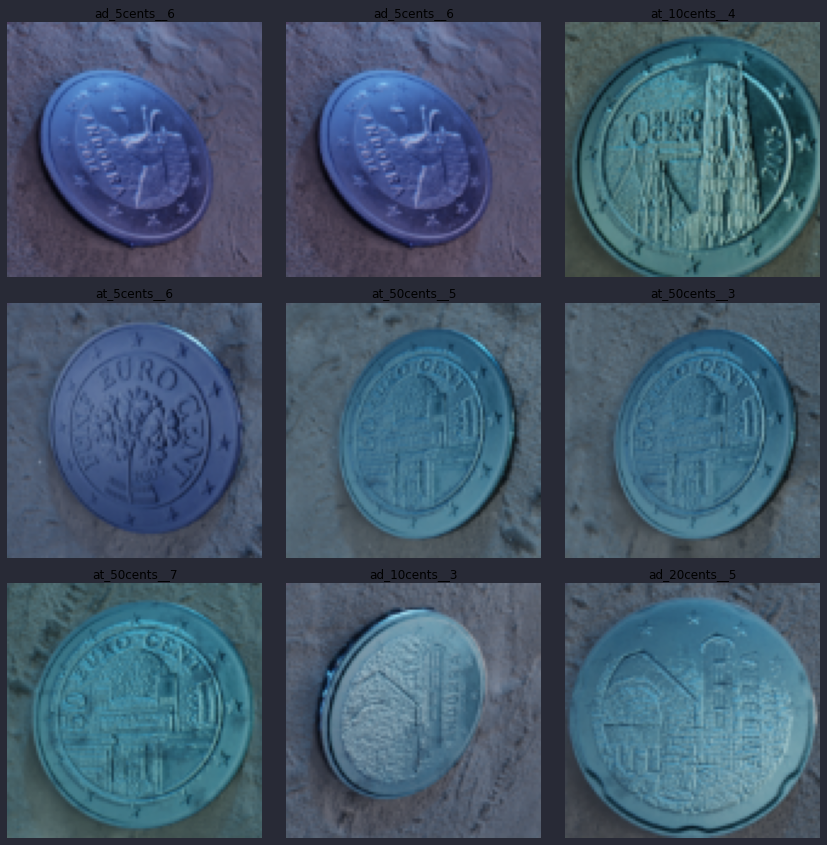

In [31]:
# from train dataset, show in a grid 3x3 images randomly selected, with the label on the top
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
# set small space between images
fig.subplots_adjust(hspace=0.1, wspace=0)
# set background color
fig.patch.set_facecolor('#282A36') # type: ignore
# set color of the text
plt.rcParams['text.color'] = '#ecf0f1'  # type: ignore

for i in range(3):
    for j in range(3):
        # select a random image
        index = random.randint(0, len(train_images))
        image = train_images[index]
        label = train_labels[index]
        label = f"{label['country']}_{label['coin_value']}_{label['specificity']}_{label['id']}"
        # show the image
        axs[i, j].imshow(image) # type: ignore
        axs[i, j].set_title(label)  # type: ignore
        # remove the axis
        axs[i, j].axis("off")  # type: ignore

## 3. Build the model

Let's say that here we have a clean Tensorflow dataset:
    
- `train_ds` is the training dataset
- `test_ds` 
- `val_ds` is the validation dataset
  
Each dataset is a `tf.data.Dataset` object.

we also have Anchor, Positive and Negative images.

### 3.1 The embedding model